### Carregamento da base de dados

In [50]:
import pandas as pd
notas = pd.read_excel('notas_faculdade.xlsx')
notas

,estudante,finanças,custos,marketing,atuária
0,Gabriela,5.8,4.0,1.0,6.0
1,Luiz Felipe,3.1,3.0,10.0,2.0
2,Patrícia,3.1,4.0,4.0,4.0
3,Gustavo,10.0,8.0,8.0,8.0
4,Letícia,3.4,2.0,3.2,3.2
...,...,...,...,...,...
95,Sheila,7.7,4.3,5.2,5.1
96,Pedro,9.0,6.0,4.0,9.8
97,Horácio,9.3,6.0,7.0,7.0
98,Leandro,9.0,6.5,3.0,9.0


### Estatísticas descritivas

In [51]:
notas.describe()

,finanças,custos,marketing,atuária
count,100.000000,100.000000,100.000000,100.000000
mean,5.834000,4.717000,5.668000,5.314000
std,3.122749,2.455999,2.828351,2.513078
min,0.600000,1.900000,1.000000,1.700000
25%,3.100000,2.900000,3.000000,3.200000
50%,5.800000,4.000000,6.000000,5.000000
75%,9.000000,6.000000,8.000000,7.025000
max,10.000000,10.000000,10.000000,10.000000


### Coeficientes de correlação de Pearson para cada par de variáveis

In [52]:
notas.iloc[:, 1:5].corr().style.background_gradient(cmap='coolwarm')

,finanças,custos,marketing,atuária
finanças,1.000000,0.755550,-0.029531,0.710871
custos,0.755550,1.000000,0.002856,0.808092
marketing,-0.029531,0.002856,1.000000,-0.044346
atuária,0.710871,0.808092,-0.044346,1.000000


### Teste de esfericidade de Bartlett

In [53]:
#%% Teste de Bartlett

from scipy.stats import bartlett
stats, pvalue = bartlett(notas.iloc[:, 1], notas.iloc[:, 2], notas.iloc[:, 3])

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
notas_pca = notas[['finanças', 'custos', 'marketing', 'atuária']]

bartlett, p_value = calculate_bartlett_sphericity(notas_pca)

print(f'Bartlett statistic: {bartlett}')

print(f'p-valor : {p_value}')

Bartlett statistic: 191.87909970380863
p-valor : 1.0139139940945954e-38


O teste de esfericidade de Bartlett testa a hipótese de que sua matriz de correlação é uma matriz de identidade, o que indicaria que suas variáveis estão desrelacionadas e, portanto, inadequadas para a detecção de estrutura. Os valores pequenos (menos de 0,05) do nível de significância indicam que uma análise de fator pode ser útil com seus dados.

### Teste de Kaiser-Meyer-Olkin (KMO)

In [54]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(notas_pca)
kmo_model

0.7373353310829559

In [55]:
pd.DataFrame({
    'KMO': ['KMO ≥ 0,9', '0,8 ≤ KMO < 0,9', '0,7 ≤ KMO < 0,8', '0,6 ≤ KMO < 0,7', '0,5 ≤ KMO < 0,6', 'KMO < 0,5'],
    'Adequação': ['Muito boa', 'Boa', 'Média', 'Razoável', 'Má', 'Inaceitável']
})

,KMO,Adequação
0,"KMO ≥ 0,9",Muito boa
1,"0,8 ≤ KMO < 0,9",Boa
2,"0,7 ≤ KMO < 0,8",Média
3,"0,6 ≤ KMO < 0,7",Razoável
4,"0,5 ≤ KMO < 0,6",Má
5,"KMO < 0,5",Inaceitável


De acordo com os dois testes, é adequado utilizar o PCA nesse dataset.

### Eigenvalues (autovalores)

In [56]:
#%% Definindo a PCA (procedimento preliminar)
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.fit(notas_pca)

#%% Obtendo os Eigenvalues (autovalores)

ev, v = fa.get_eigenvalues()

print(ev)

# Soma dos eigenvalues = 4 (quantidade de variáveis na análise)
# Também representa a quantidade máxima de possíveis fatores na análise

[2.51812681 1.0003793  0.29761585 0.18387804]


### Variância compartilhada pelas variáveis originais para a formação de cada fator

In [57]:
#%% Parametrizando a PCA para dois fatores (autovalores > 1)

fa.set_params(n_factors = 2, method = 'principal', rotation = None)
fa.fit(notas_pca)

#%% Eigenvalues, variâncias e variâncias acumulada

eigen_fatores = fa.get_factor_variance()
eigen_fatores

tabela_eigen = pd.DataFrame(eigen_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

tabela_eigen

,Autovalor,Variância,Variância Acumulada
Fator 1,2.518127,0.629532,0.629532
Fator 2,1.000379,0.250095,0.879627


### Cálculo dos scores fatoriais

In [58]:
#%% Determinando as cargas fatoriais
cargas_fatores = fa.loadings_
tabela_cargas = pd.DataFrame(cargas_fatores)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = notas_pca.columns
tabela_cargas

,Fator 1,Fator 2
finanças,0.895398,0.007086
custos,0.934033,0.048581
marketing,-0.042466,0.998933
atuária,0.917697,-0.010133


### Coeficientes de correlação de Pearson para cada par de fatores (ortogonais)

In [59]:
#%% Resultados dos fatores para as observações do dataset (predict)

predict_fatores= pd.DataFrame(fa.transform(notas_pca))
predict_fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(predict_fatores.columns)]

predict_fatores

,Fator 1,Fator 2
0,0.015232,-1.673452
1,-1.082468,1.510196
2,-0.603231,-0.607015
3,1.352586,0.891321
4,-0.984279,-0.926699
...,...,...
95,0.121867,-0.169227
96,1.220881,-0.577316
97,0.829146,0.499201
98,1.186171,-0.918969


### Coeficientes de correlação de Pearson para cada par de fatores (ortogonais)

In [60]:
# Coeficientes de correlação de Pearson para cada par de fatores (ortogonais)
predict_fatores.corr().round(2)

,Fator 1,Fator 2
Fator 1,1.0,0.0
Fator 2,0.0,1.0


### Cálculo das comunalidades

In [62]:
#%% Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = notas_pca.columns
tabela_comunalidades

tabela_comunalidades

,Comunalidades
finanças,0.801788
custos,0.874778
marketing,0.999670
atuária,0.842271


In [48]:
# Definição da quantidade de fatores com eigenvalues maiores que 1
len(ev[ev > 1])

2

In [69]:
#%% Determinando as comunalidades
fa.set_params(n_factors = 2, method = 'principal', rotation = None)
fa.fit(notas_pca)

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = notas_pca.columns
tabela_comunalidades.round(3)



,Comunalidades
finanças,0.802
custos,0.875
marketing,1.000
atuária,0.842


### Visualização das comunalidades

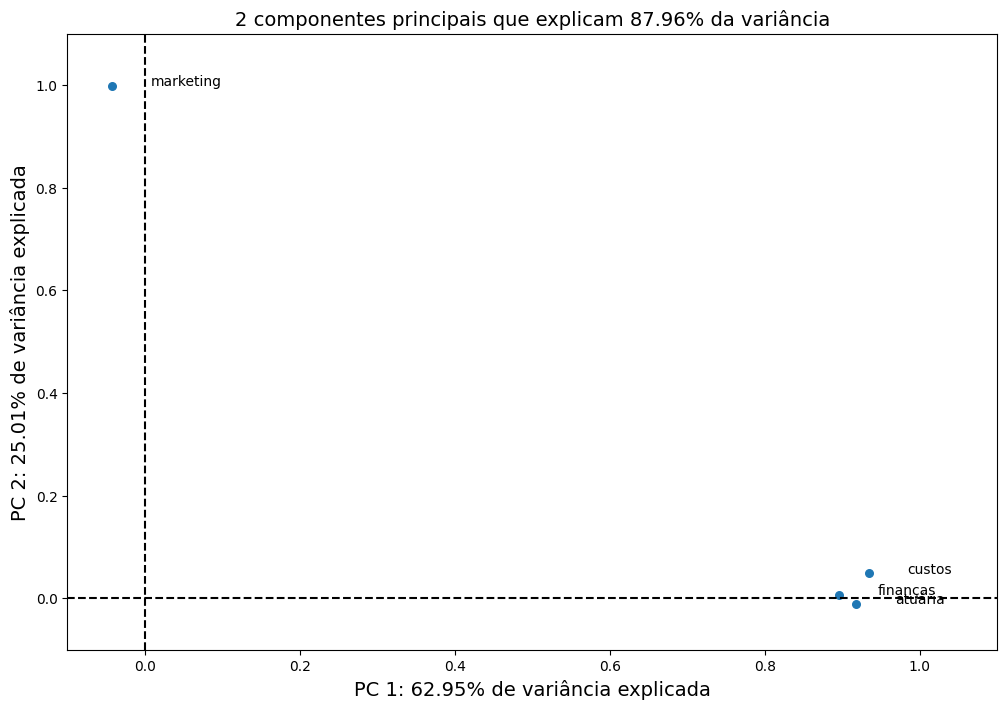

In [67]:
#%% Gráfico das cargas fatoriais e suas variâncias nos componentes principais

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

tabela_cargas_chart = tabela_cargas.reset_index()

plt.scatter(tabela_cargas_chart['Fator 1'], tabela_cargas_chart['Fator 2'], s=30)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = tabela_cargas_chart['Fator 1'],
            y = tabela_cargas_chart['Fator 2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='black', ls='--')
plt.axvline(x=0, color='black', ls='--')
plt.ylim([-0.1,1.1])
plt.xlim([-0.1,1.1])
plt.title(f"{tabela_eigen.shape[0]} componentes principais que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=14)
plt.xlabel(f"PC 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=14)
plt.ylabel(f"PC 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=14)
plt.show()

#####################

In [72]:
X = notas.iloc[:, 1:5].values

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
autovalores = pca.explained_variance_
autovetores = pca.components_
pca_samples = pca.transform(X)

### Gráfico da variância acumulada dos componentes principais

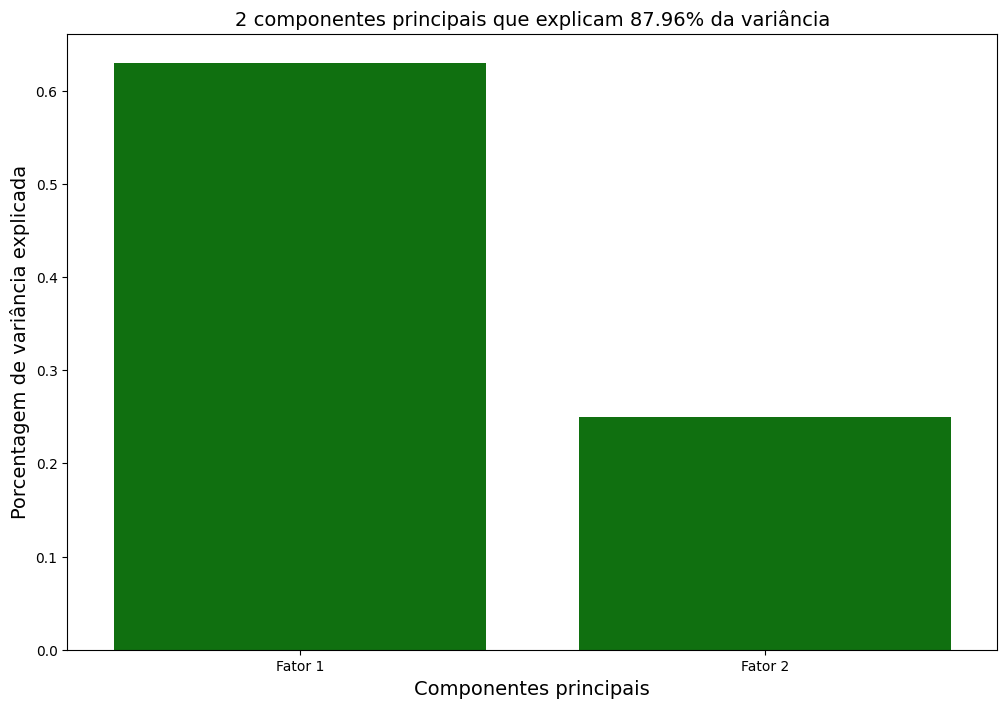

In [76]:
import seaborn as sns
plt.figure(figsize=(12,8))

plt.title(f"{tabela_eigen.shape[0]} componentes principais que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=14)
sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, color='green')
plt.xlabel("Componentes principais", fontsize=14)
plt.ylabel("Porcentagem de variância explicada", fontsize=14)
plt.show()

### Adicionando os fatores extraídos no banco de dados original

In [78]:
pd.concat([notas, predict_fatores], axis=1)

,estudante,finanças,custos,marketing,atuária,Fator 1,Fator 2
0,Gabriela,5.8,4.0,1.0,6.0,0.015232,-1.673452
1,Luiz Felipe,3.1,3.0,10.0,2.0,-1.082468,1.510196
2,Patrícia,3.1,4.0,4.0,4.0,-0.603231,-0.607015
3,Gustavo,10.0,8.0,8.0,8.0,1.352586,0.891321
4,Letícia,3.4,2.0,3.2,3.2,-0.984279,-0.926699
...,...,...,...,...,...,...,...
95,Sheila,7.7,4.3,5.2,5.1,0.121867,-0.169227
96,Pedro,9.0,6.0,4.0,9.8,1.220881,-0.577316
97,Horácio,9.3,6.0,7.0,7.0,0.829146,0.499201
98,Leandro,9.0,6.5,3.0,9.0,1.186171,-0.918969
